# Workshop on object detection

Course: Vision Systems

Website: https://www.iss.nus.edu.sg/executive-education/course/detail/vision--systems/artificial-intelligence

Contact: Tian Jing

Email: tianjing@nus.edu.sg

Objective: In this workshop, we will perform object detection on a finetuned YOLO model from ultralytics.

Dataset: nuts and bolts detection, https://github.com/Stroma-Vision/machine-learning-challenge


In [ ]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import json
from PIL import Image

np.random.seed(666)

In [ ]:
# Mount your drive
# Run this cell, then you’ll see a link, click on that link, allow access
# Copy the code that pops up, Paste it in the box, Hit enter

from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder, please keep ''/content/gdrive/My Drive/XXX' in the path
# and change XXX to be your own folder. The pathname is case sensitive.
import os
os.chdir('/content/gdrive/My Drive/VSE/Day2/detection')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 archive    nuts_and_bolts.yaml   test1.jpg  ' VSE_Day2_wk_detection_yourname.ipynb'   yolo11s.pt
 datasets   runs		  test2.jpg   yolo11n.pt			       yolo8s.pt


In [ ]:
# Insall the YOLO model
!pip install ultralytics
from ultralytics import YOLO


In [ ]:
######################################################################################
# Auxiliary function to draw the bounding boxes on objects for randomly picked images:
######################################################################################

# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

# Function to draw the bounding boxes.
def plot_box(image, bboxes, labels, colors):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        )

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name,
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image


# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples, colors):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels, colors)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()


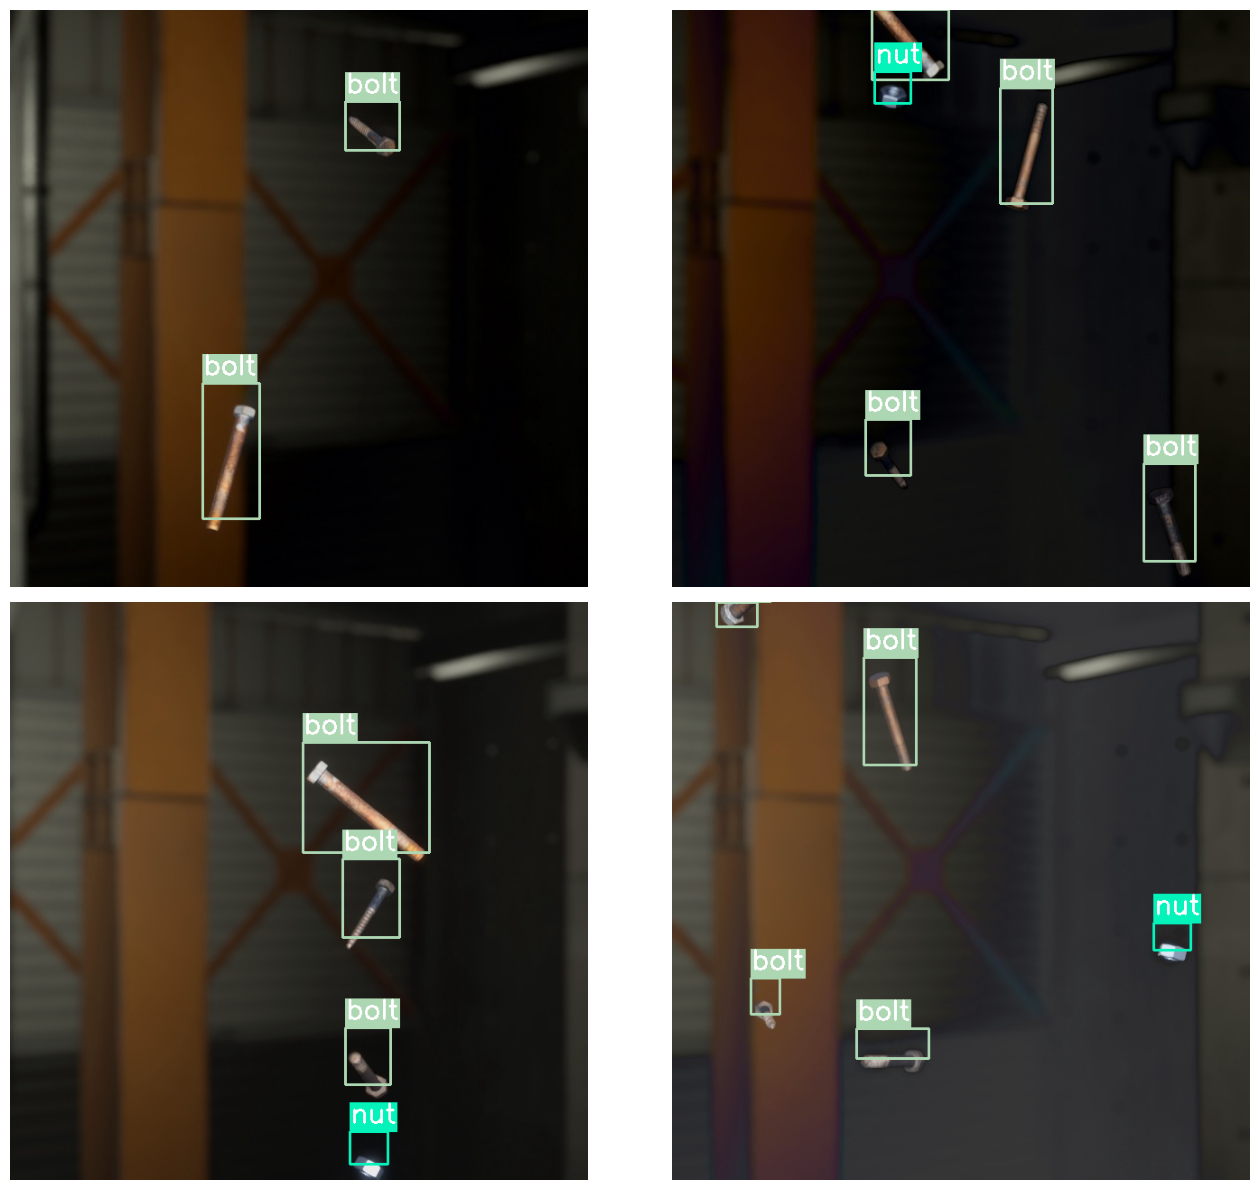

In [ ]:
# Display sample images with annotations
class_names = ['bolt', 'nut']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

plot(
    image_paths='datasets/train/images/*',
    label_paths='datasets/train/labels/*',
    num_samples=4,
    colors = colors
)


In [ ]:

# Load a model
model = YOLO('yolo8s.pt')  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data='nuts_and_bolts.yaml', epochs=5, imgsz=640, batch=64)


Ultralytics 8.3.35 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo8s.pt, data=nuts_and_bolts.yaml, epochs=5, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, l

100%|██████████| 5.35M/5.35M [00:00<00:00, 56.5MB/s]


AMP: checks passed ✅


train: Scanning /content/gdrive/My Drive/VSE/Day2/detection/datasets/train/labels.cache... 1054 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1054/1054 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/gdrive/My Drive/VSE/Day2/detection/datasets/valid/labels.cache... 101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      14.3G      2.166      3.333      1.793         93        640: 100%|██████████| 17/17 [00:26<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]

                   all        101        201      0.714      0.244      0.344      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      14.2G      1.069     0.9332      1.011        120        640: 100%|██████████| 17/17 [00:24<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]

                   all        101        201      0.872      0.795      0.783      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      14.2G     0.8389     0.6351     0.9327        122        640: 100%|██████████| 17/17 [00:23<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

                   all        101        201      0.869      0.871       0.88      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5        14G     0.7583     0.5449     0.9131        111        640: 100%|██████████| 17/17 [00:23<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]

                   all        101        201      0.989       0.92      0.993      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5        14G     0.6632     0.4865     0.8904        100        640: 100%|██████████| 17/17 [00:22<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all        101        201      0.978      0.991      0.994       0.78



5 epochs completed in 0.043 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 22.5MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.35 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


                   all        101        201      0.978      0.991      0.994      0.783
                  bolt        101        158      0.987      0.982      0.994      0.857
                   nut         43         43      0.969          1      0.995       0.71
Speed: 0.2ms preprocess, 5.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train4



image 1/1 /content/gdrive/My Drive/VSE/Day2/detection/test1.jpg: 640x640 3 bolts, 16.3ms
Speed: 2.6ms preprocess, 16.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


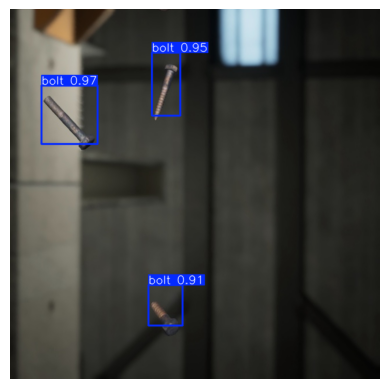

In [ ]:
# Apply inference on tst image

results = model('test1.jpg')

# Show the results
im_array = results[0].plot()  # plot a BGR numpy array of predictions
im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
plt.axis('off')
plt.imshow(im)
plt.show()


$\color{red}{\text{Discussions}}$

Q1. Study the Ultralytics toolbox
https://github.com/ultralytics/ultralytics/blob/main/ultralytics/utils/loss.py and state three loss functions that are used in object detection.

Q2. Study the Ultralytics document https://docs.ultralytics.com/reference/data/augment
and state three augmentation methods that are useful for this nuts and bolts dataset.

Q3. Can we also apply your identified augmentation methods on the test time? You might want to take a look at the reference paper on test-time-augmentation (TTA), https://www.nature.com/articles/s41598-020-61808-3

In [ ]:
# Provide your answers to Q1 here
# 1. Box Loss (IoU Loss): This loss evaluates how well the predicted boxes overlap with the actual object locations, ensuring precise localization. The Intersection over Union (IoU) metric is commonly used for this purpose.
# 2. Classification Loss (Cls Loss): This component calculates the error in classifying objects, ensuring that each detected object is assigned the correct category.
# 3. Distribution Focal Loss (DFL Loss): DFL emphasizes the importance of accurate localization by adjusting the loss contribution based on the confidence of the predictions, thereby refining the bounding box coordinates

# Provide your answers to Q2 here
# 1. Mosaic Augmentation: Combines four different images into one during training, allowing the model to learn from varied contexts and object scales.
# 2. Random Perspective Transformation: Applies random scaling, rotation, and translation to images, altering the perspective to simulate different viewing angles.
# 3. MixUp Augmentation: Creates new training samples by mixing two images and their corresponding labels, effectively increasing the diversity of the training data.

# Provide your answers to Q3 here
# Mosaic Augmentation and MixUp Augmentation are not suitable for test-time augmentation. Random Perspective Transformation can be cautiously used at test time.
# It should be applied conservatively to avoid excessive distortions that may mislead the mode.
# TTA methods such as flipping, scaling, and color adjustments are more effective and widely used.


**After you finish the workshop, rename and submit your .ipynb file.**